In [1]:
import os
import cv2
import torch
import clip
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [18]:
# Assuming 'model' is your pre-trained model and 'device' is your device (e.g., 'cuda' or 'cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

class_mapping = {
    'Jump': 0,
    'Run': 1,
    'Sit': 2,
    'Stand': 3,
    'Turn': 4,
    'Walk': 5
}

# Transform to be applied to each frame
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the folder containing images
folder_path = "C:\\Users\\songyu\\Desktop\\output_images_enhance"
# Lists to store features and labels
fused_feature=[]
fused_lables=[]
# Read and process each image in the folder
for video_folder in tqdm(os.listdir(folder_path)):
    category=video_folder.split('_')[0]
    all_features = []
    all_labels = []
    video_path=os.path.join(folder_path,video_folder)
    for image_name in os.listdir(video_path):
        image_path = os.path.join(video_path, image_name)
        frame = cv2.imread(image_path)
        frame = transform(frame)
        frame = torch.unsqueeze(frame, 0)

        with torch.no_grad():
            features = model.encode_image(frame.to(device))
            all_features.append(features)    
    fused_feature.append(torch.mean(torch.squeeze(torch.stack(all_features)), dim=0).cpu())
    fused_lables.append(class_mapping[category])

100%|██████████| 150/150 [02:06<00:00,  1.19it/s]


In [21]:
X_train = np.array(torch.stack(fused_feature))
y_train = np.array(fused_lables)

print(X_train.shape)
print(y_train)

(150, 512)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5]


In [30]:
# 设置测试数据集文件路径
test_mapping_path = r'C:\\Users\\songyu\\Desktop\\EE6222 train and validate 2023\\validate.txt' 

# 读取测试数据集映射
test_mapping = np.genfromtxt(test_mapping_path, dtype=str)

# 收集数据和标签
fused_feature_test=[]
fused_lables_test=[]

test_path='C:\\Users\\songyu\\Desktop\\output_images_enhance_test'
# Lists to store features and labels
# Read and process each image in the folder
for entry in tqdm(test_mapping):
    video_test = []
    lable_teat = []
    _,class_index,video_name = entry
    video_extend=video_name.split('.')[0]
    video_path=os.path.join(test_path,video_extend)
    for image_name in os.listdir(video_path):
        image_path = os.path.join(video_path, image_name)
        frame = cv2.imread(image_path)
        frame = transform(frame)
        frame = torch.unsqueeze(frame, 0)
        with torch.no_grad():
            features = model.encode_image(frame.to(device))
            video_test.append(features)

    fused_lables_test.append(class_index)
    fused_feature_test.append(torch.mean(torch.squeeze(torch.stack(video_test)), dim=0).cpu())

100%|██████████| 96/96 [01:24<00:00,  1.14it/s]


In [39]:
video_test=np.array(torch.stack(fused_feature_test,dim=0))
lable_teat=np.array(fused_lables_test)


(96, 512)


In [42]:
print(lable_teat)
lable_teat_true = [int(x) for x in lable_teat]
print(lable_teat_true)

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '3' '3' '3' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5'
 '5' '5' '5' '5' '5' '5']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [57]:
# 构建SVM模型
svm_model = SVC(kernel='rbf',C=0.1)

# 训练模型
svm_model.fit(X_train, y_train)

# 预测测试集
y_pred = svm_model.predict(video_test)

print(y_pred)

cm = confusion_matrix(lable_teat_true, y_pred)

# 评估模型性能
accuracy = accuracy_score(lable_teat_true, y_pred)
print(f"Accuracy: {accuracy}")

[3 5 0 0 5 5 5 1 5 0 0 0 0 0 0 0 2 5 5 3 1 1 1 1 1 1 5 5 5 1 1 5 2 5 2 5 5
 5 5 5 5 5 1 5 5 1 5 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 0 5 0 5 0 0 0
 5 5 5 5 5 5 1 5 3 2 1 2 2 2 2 2 2 2 2 1 1 1]
Accuracy: 0.20833333333333334


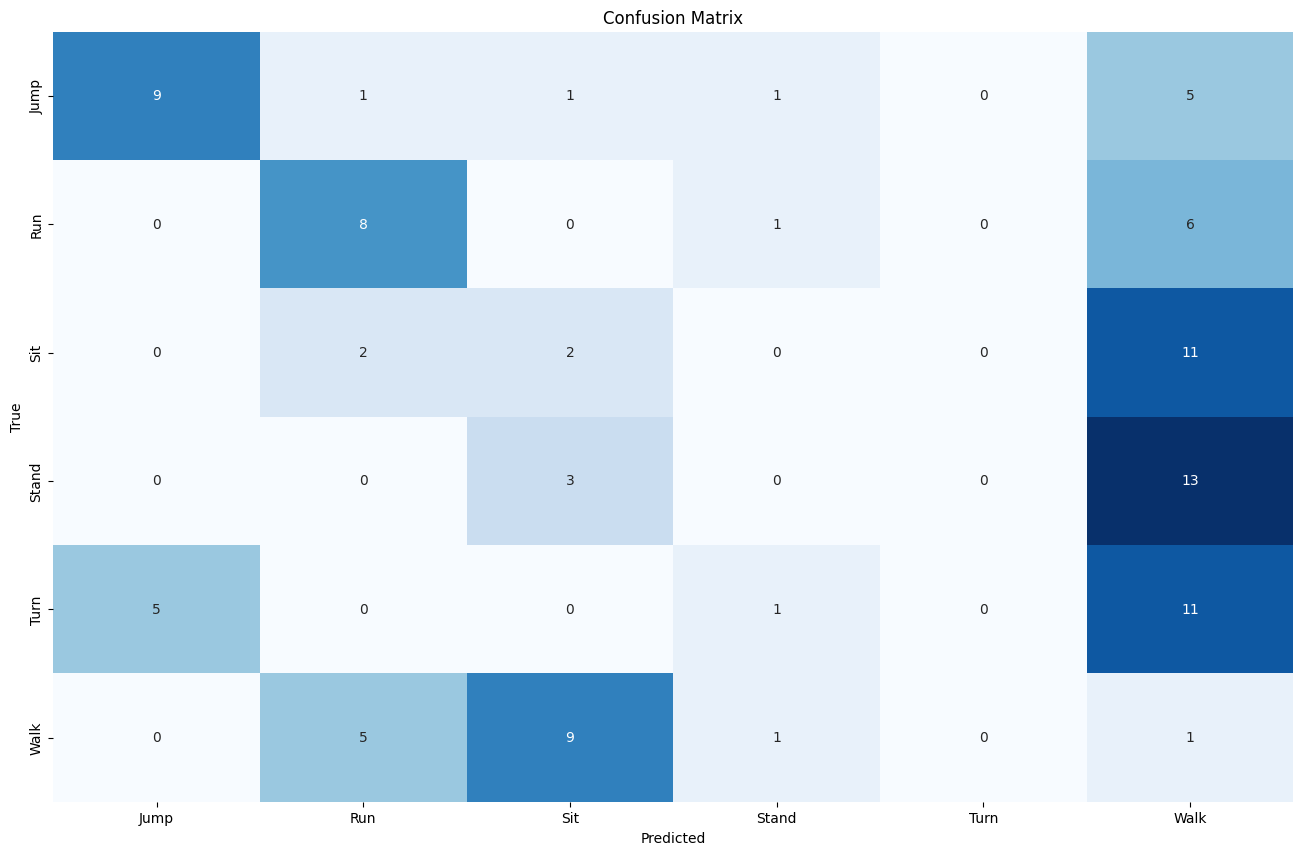

In [58]:

# 画图
plt.figure(figsize=(16, 10))

class_labels = ["Jump", "Run", "Sit", "Stand", "Turn", "Walk"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()